## Preprocessing unit

In [ ]:
import numpy as np
import pandas as pd
import os
import sys
from tqdm import tqdm
import pickle
import time
from glob import glob
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from google.colab import drive
drive.mount('/content/drive',force_remount=True)


class Preprocessing:
    def __init__(self, data_path, labels, normalise=False, mode="emuc"):
        self.data_path = data_path
        self.labels = labels
        self.normalise = normalise
        self.mode = mode

    def load_csv_dataset(self, data_path, isControlClass, trial):
        # Access the embb_clean files and then get their data and convert into dataframe
        embb_files = glob(os.path.join(data_path, os.path.join(trial, "embb_*clean.csv")))
        print(os.path.join(data_path, os.path.join(trial, "embb_*clean.csv")))

        embb_data = pd.concat([pd.read_csv(f, sep=",") for f in embb_files])
        embb_data['label'] = [0 for i in range(len(embb_data))]

        # Access the mmtc_clean files and then get their data and convert into dataframe
        mmtc_files = glob(os.path.join(data_path, os.path.join(trial, "mmtc_*clean.csv")))
        mmtc_data = pd.concat([pd.read_csv(f, sep=",") for f in mmtc_files])
        mmtc_data['label'] = [1 for i in range(len(mmtc_data))]

        # If the column ul_rssi is present in mmtc, just drop it for column alignment
        if 'ul_rssi' in mmtc_data.columns:
            mmtc_data = mmtc_data.drop(['ul_rssi'], axis=1)
        if 'ul_rssi' in embb_data.columns:
            embb_data = embb_data.drop(['ul_rssi'], axis=1)

        # Access the urllc_clean files and then get their data and convert into dataframe
        urllc_files = glob(os.path.join(data_path, os.path.join(trial, "urllc*_*clean.csv")))
        urllc_data = pd.concat([pd.read_csv(f, sep=",") for f in urllc_files])
        urllc_data['label'] = [2 for i in range(len(urllc_data))]

        print(os.path.join(data_path, os.path.join(trial, "urllc*_*clean.csv")))

        # If the control class is present, access it from null_clean.csv file and then concat it
        if isControlClass and os.path.exists(os.path.join(data_path, os.path.join(trial, "null_clean.csv"))):
            ctrl_data = pd.read_csv(os.path.join(data_path, os.path.join(trial, "null_clean.csv")), sep=",")
            ctrl_data['label'] = [3 for i in range(len(ctrl_data))]
            df = pd.concat([embb_data, mmtc_data, urllc_data, ctrl_data])
        else:
            df = pd.concat([embb_data, mmtc_data, urllc_data])

        # Drop unnecessary columns like timestamp, tc_errors downlink, and dl_cqi
        columns_drop = ['Timestamp', 'tx_errors downlink (%)']
        df.drop(columns_drop, axis=1, inplace=True)
        return df

    def gen_slice_data(self, trials):
        isControlClass = True if "c" in self.mode else False
        df = pd.DataFrame()
        for ix, trial in enumerate(trials):
            print(f"Generating dataframe: {trial}")

            new_df = self.load_csv_dataset(self.data_path, isControlClass, trial)
            df = pd.concat([df, new_df])

        # Normalize the data if required
        columns_maxim = {}
        if self.normalise:
            for i in df.columns:
                if i != 'label':
                    col = df[i]
                    val_max = df[i].max()
                    val_min = col.min()
                    print(f"Normalizing column, {i} -- Max: {val_max} -- Min: {val_min}")
                    df[i] = (col - val_min) / (val_max - val_min)
                    columns_maxim[i] = {"max": val_max, "min": val_min}

        # Print the number of entries for each class
        classes = [0, 1, 2, 3] if self.mode == "emuc" else [0, 1, 2]
        for c in classes:
            print(f"Class: {c}\tEntries: {len(df[df['label'] == c])}")

        return df, columns_maxim

class ApplyHeuristics:
    def __init__(self,df):
        self.df=df
    def applyHeuristic(self):
        kpi_columns=self.df.columns[:-1]
        zero_counts=(self.df[kpi_columns]==0).sum(axis=1)
        new_label=3
        self.df.loc[zero_counts>11,'label']=new_label
        return self.df
    def save_csv(self,df,path="/content/drive/My Drive/6G/CIP_Group_Sanjeev/logs/dataset_analysis.csv"):
        df.to_csv(path,index=False)
        print("File saved at",path)


Mounted at /content/drive


# Plotting unit

In [ ]:
import matplotlib.pyplot as plt

class GraphView:
    def __init__(self, df, labels):
        self.df = df
        self.labels = labels
        self.labels_list = []
        self.zero_percent_list = []

    def plot_traffic_class_distribution(self):
        # Count occurrences of each class
        col = [len(self.df[self.df['label'] == c]) for c in self.labels]
        print(col)

        # Plot the traffic class distribution bar graph
        plt.figure(figsize=(8, 5))
        plt.bar(self.labels.values(), col, color=['blue', 'red', 'green', 'purple'])

        # Labels and title
        plt.xlabel("Traffic Class")
        plt.ylabel("Count")
        plt.title("Traffic Class Distribution")
        plt.show()

    def calculate_zero_populated_rows(self):
        # Calculate the zero-populated rows for each class
        for i in self.labels.keys():
            print("Class : ", self.labels[i], "Entries : ", len(self.df[self.df['label'] == i]))
            zero_rows = len(self.df[(self.df['label'] == i) & ((self.df == 0).astype(int).sum(axis=1) > 11)])
            n_samples = len(self.df[self.df['label'] == i])
            self.labels_list.append(self.labels[i])
            self.zero_percent_list.append(round(zero_rows / n_samples * 100, 2))
            print(f"Out of {n_samples} samples, {zero_rows} are Zero populated rows which is about {round(zero_rows / n_samples * 100, 2)}%")

        print("\nRows with more than 11 zero KPIs are zero populated rows")

    def plot_zero_populated_rows(self):
        # Plotting the percentage of zero-populated rows per traffic class
        plt.figure(figsize=(10, 5))
        plt.bar(self.labels_list, self.zero_percent_list, color=['blue', 'red', 'green', 'purple'])
        plt.xlabel("Traffic Classes")
        plt.ylabel("Percentage of Zero Populated Rows")
        plt.title("Zero Populated Rows Percentage KPI rows per class")
        plt.ylim(0, 100)
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.show()

    def generate_graphs(self):
        # Method to calculate and plot both graphs
        self.plot_traffic_class_distribution()
        self.calculate_zero_populated_rows()
        self.plot_zero_populated_rows()





# Mean and standard variance analysis for kpis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class KPIAnalysis:
    def __init__(self, df, labels):
        self.df = df
        self.labels = labels
        self.kpis = df.columns[:-1]  # Extract KPI feature names (should be 16)
        self.num_kpis = len(self.kpis)

    def calc_mean(self, data, cl, no_zeros=False):
        if no_zeros and cl != 3:  # For control classes, don't exclude zero KPI rows
            data = data.loc[(data == 0).astype(int).sum(axis=1) < 11]  # Ignore rows with more than 11 KPIs as zero
        return data.mean().tolist()[:-1]

    def calc_std(self, data, cl, no_zeros=False):
        if no_zeros and cl != 3:  # For control classes, don't exclude zero KPI rows
            data = data.loc[(data == 0).astype(int).sum(axis=1) < 11]  # Ignore rows with more than 11 KPIs as zero
        return data.std().tolist()[:-1]

    def plot_kpi_analysis(self, no_zeros=False):
        x = np.arange(self.num_kpis)  # Generate x-axis values

        # Create a 2x2 grid of subplots (one for each traffic class)
        fig, ax = plt.subplots(2, 2, figsize=(18, 10))

        # Loop through the traffic classes and calculate means and std deviations
        for i in range(2):
            for j in range(2):
                class_id = i * 2 + j  # Compute class index (0, 1, 2, 3)

                # Compute KPI means and standard deviations for the given class
                kpi_means = self.calc_mean(self.df[self.df['label'] == class_id], class_id, no_zeros)
                kpi_stds = self.calc_std(self.df[self.df['label'] == class_id], class_id, no_zeros)

                # Plot bar chart for KPI statistics
                ax[i][j].bar(
                    x, kpi_means,
                    yerr=kpi_stds,
                    align='center', alpha=0.7, ecolor='black', capsize=4
                )

                # Formatting the subplot
                ax[i][j].set_title(f"Traffic Class: {self.labels[class_id]}", fontsize=14, fontweight='bold')
                ax[i][j].set_xlabel("KPI Features", fontsize=12)
                ax[i][j].set_ylabel("Mean Value", fontsize=12)
                ax[i][j].set_xticks(x)  # Set x-ticks
                ax[i][j].set_xticklabels(self.kpis, rotation=45, ha='right', fontsize=10)  # Assign KPI names as labels

        # Adjust layout to prevent overlap
        plt.tight_layout()

        # Show the plot
        plt.show()

    def print_kpi_names(self):
        # Print KPI index and names
        for i in range(self.num_kpis):
            print(f"{i}: {self.kpis[i]}", end=" ; ")




# Dimensionality Reduction PCA

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

class PCAAnalysis:
    def __init__(self, df, n_components=6):
        self.df = df
        self.kpis = df.columns[:-1]  # Extract KPI features (excluding label)
        self.n_components = n_components
        self.X = df[self.kpis].values  # Convert to numpy array
        self.pca = PCA(n_components=n_components)
        self.X_pca = self.pca.fit_transform(self.X)  # PCA transformation
        self.explained_variance = self.pca.explained_variance_ratio_

    def explained_variance_summary(self):
        # Output the cumulative and total explained variance
        print(f"Explained Variance per Component: {self.explained_variance}")
        print(f"Cumulative Variance Explained: {self.explained_variance.cumsum()}")
        print(f"Total Variance Explained: {self.explained_variance.sum()}")

    def plot_2d_pca(self):
        # Create a dataframe with PCA components and label
        df_pca = pd.DataFrame(self.X_pca, columns=[f'PC{i+1}' for i in range(self.n_components)])
        df_pca['label'] = self.df['label'].reset_index(drop=True)

        # Scatter plot for first two principal components
        plt.figure(figsize=(12, 6))
        sns.scatterplot(
            x=df_pca["PC1"], y=df_pca["PC2"],
            hue=df_pca["label"],  # Color by class labels
            palette="tab10",
            alpha=0.5
        )
        plt.title("PCA: First Two Principal Components")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.legend(title="Class")
        plt.show()

    def plot_3d_pca(self):
        # Create a dataframe with PCA components and label
        df_pca = pd.DataFrame(self.X_pca, columns=[f'PC{i+1}' for i in range(self.n_components)])
        df_pca['label'] = self.df['label'].reset_index(drop=True)

        # 3D scatter plot for the first three principal components
        fig = plt.figure(figsize=(10, 7))
        ax = fig.add_subplot(111, projection='3d')

        # Scatter plot using first 3 PCs
        ax.scatter(df_pca["PC1"], df_pca["PC2"], df_pca["PC3"],
                   c=pd.factorize(df_pca["label"])[0], cmap="tab10", alpha=0.6)

        ax.set_xlabel("PC1")
        ax.set_ylabel("PC2")
        ax.set_zlabel("PC3")
        ax.set_title("PCA: First Three Principal Components")
        plt.show()

    def get_pca_components(self):
        # Return PCA components
        return self.pca.components_

    def get_pca_dataframe(self):
        # Return the transformed data as a DataFrame
        df_pca = pd.DataFrame(self.X_pca, columns=[f'PC{i+1}' for i in range(self.n_components)])
        df_pca['label'] = self.df['label'].reset_index(drop=True)
        return df_pca




# Dimensionality Reduction TSNE

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

class TSNEAnalysis:
    def __init__(self, df, n_components=2, perplexity=30, n_iter=300, random_state=42):
        """
        Initialize the TSNEAnalysis class with the dataframe and t-SNE parameters.

        :param df: DataFrame containing the feature columns and a 'label' column for class labels.
        :param n_components: Number of components for t-SNE transformation (default is 2).
        :param perplexity: Perplexity for t-SNE (default is 30).
        :param n_iter: Number of iterations for t-SNE (default is 300).
        :param random_state: Random state for reproducibility (default is 42).
        """
        self.df = df
        self.features = df.drop(columns=['label'])  # Features excluding 'label'
        self.labels = df['label']  # Class labels
        self.n_components = n_components
        self.perplexity = perplexity
        self.n_iter = n_iter
        self.random_state = random_state

        # Perform t-SNE transformation
        self.tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state,
                         verbose=1, n_iter=n_iter)
        self.tsne_results = self.tsne.fit_transform(self.features)

        # Create a DataFrame with t-SNE results
        self.df_tsne = pd.DataFrame({'TSNE-1': self.tsne_results[:, 0], 'TSNE-2': self.tsne_results[:, 1], 'label': self.labels})

    def plot_tsne(self):
        """
        Plot the 2D t-SNE visualization using seaborn.
        """
        plt.figure(figsize=(10, 7))

        # Create a scatter plot using Seaborn
        sns.scatterplot(
            x="TSNE-1", y="TSNE-2",
            hue=self.df_tsne["label"],  # Color by label/class
            palette="tab10",  # Use a distinct color palette
            data=self.df_tsne,
            alpha=0.7  # Set transparency for better visibility
        )

        # Set title and labels
        plt.title("t-SNE Visualization of Features")
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")

        # Show the legend
        plt.legend(title="Class Labels", bbox_to_anchor=(1.05, 1), loc='upper left')

        # Display the plot
        plt.show()

    def get_tsne_results(self):
        """
        Return the t-SNE results as a DataFrame for further analysis.
        """
        return self.df_tsne



# **imensionality Reduction UMAP**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap

class UMAPAnalysis:
    def __init__(self, df, n_components=2, n_neighbors=30, min_dist=0.3, random_state=42):
        """
        Initialize the UMAPAnalysis class with the dataframe and UMAP parameters.

        :param df: DataFrame containing the feature columns and a 'label' column for class labels.
        :param n_components: Number of components for UMAP transformation (default is 2).
        :param n_neighbors: Number of neighbors for UMAP (default is 30).
        :param min_dist: Minimum distance between points for UMAP (default is 0.3).
        :param random_state: Random state for reproducibility (default is 42).
        """
        self.df = df
        self.features = df.drop(columns=['label'])  # Features excluding 'label'
        self.labels = df['label']  # Class labels
        self.n_components = n_components
        self.n_neighbors = n_neighbors
        self.min_dist = min_dist
        self.random_state = random_state

        # Perform UMAP transformation
        self.umap = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state)
        self.umap_results = self.umap.fit_transform(self.features)

        # Create a DataFrame with UMAP results
        self.df_umap = pd.DataFrame(self.umap_results, columns=[f'UMAP-{i+1}' for i in range(n_components)])
        self.df_umap['label'] = self.labels.values

    def plot_umap(self):
        """
        Plot the 2D UMAP visualization using seaborn.
        """
        plt.figure(figsize=(10, 7))

        # Create a scatter plot using Seaborn
        sns.scatterplot(
            x='UMAP-1', y='UMAP-2',
            hue=self.df_umap['label'],
            palette=sns.color_palette('hsv', len(self.df_umap['label'].unique())),
            alpha=0.7,
            data=self.df_umap
        )

        # Set title and labels
        plt.title("UMAP Dimensionality Reduction (2D)")
        plt.xlabel("UMAP-1")
        plt.ylabel("UMAP-2")
        plt.legend(title="Traffic Class")

        # Display the plot
        plt.show()

    def get_umap_results(self):
        """
        Return the UMAP results as a DataFrame for further analysis.
        """
        return self.df_umap



# **Random Forest Model**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

class RandomForestModel:
    def __init__(self, data, label_column, test_size=0.2, n_estimators=100, random_state=42):
        """
        Initialize the RandomForestModel class with dataset and parameters.

        :param data: DataFrame containing the features and the label column.
        :param label_column: Name of the label column in the dataset.
        :param test_size: Proportion of the data to be used for testing (default is 0.2).
        :param n_estimators: Number of trees in the Random Forest (default is 100).
        :param random_state: Random state for reproducibility (default is 42).
        """
        self.data = data
        self.label_column = label_column
        self.test_size = test_size
        self.n_estimators = n_estimators
        self.random_state = random_state

        # Extract features and labels
        self.X = self.data.drop(columns=[self.label_column])  # Features
        self.y = self.data[self.label_column]  # Labels

        # Split the data into training and testing sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=self.test_size, random_state=self.random_state, stratify=self.y)

        # Initialize the RandomForestClassifier
        self.rf_model = RandomForestClassifier(n_estimators=self.n_estimators, random_state=self.random_state)

    def train(self):
        """Train the Random Forest model."""
        self.rf_model.fit(self.X_train, self.y_train)

    def predict(self):
        """Make predictions using the trained model."""
        return self.rf_model.predict(self.X_test)

    def evaluate(self, y_pred):
        """Evaluate the model's performance."""
        # Compute Accuracy
        accuracy = accuracy_score(self.y_test, y_pred)
        print(f"Random Forest Accuracy: {accuracy:.2f}")

        # Print Classification Report
        print("\nClassification Report:\n", classification_report(self.y_test, y_pred))

        # Compute Confusion Matrix
        conf_matrix = confusion_matrix(self.y_test, y_pred)

        # Visualize Confusion Matrix
        plt.figure(figsize=(6, 5))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(self.y), yticklabels=np.unique(self.y))
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix - Random Forest")
        plt.show()

    def run(self):
        """Train the model, make predictions, and evaluate the results."""
        self.train()
        y_pred = self.predict()
        self.evaluate(y_pred)



# **XGBoost Model**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

class XGBModel:
    def __init__(self, data, label_column, test_size=0.2, n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42):
        """
        Initialize the XGBModel class with dataset and parameters.

        :param data: DataFrame containing the features and the label column.
        :param label_column: Name of the label column in the dataset.
        :param test_size: Proportion of the data to be used for testing (default is 0.2).
        :param n_estimators: Number of trees in the XGBoost model (default is 100).
        :param learning_rate: Step size shrinkage used in the model (default is 0.1).
        :param max_depth: Maximum depth of trees (default is 6).
        :param random_state: Random state for reproducibility (default is 42).
        """
        self.data = data
        self.label_column = label_column
        self.test_size = test_size
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.random_state = random_state

        # Extract features and labels
        self.X = self.data.drop(columns=[self.label_column])  # Features
        self.y = self.data[self.label_column]  # Labels

        # Split the data into training and testing sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=self.test_size, random_state=self.random_state, stratify=self.y)

        # Initialize the XGBClassifier
        self.xgb_model = XGBClassifier(
            n_estimators=self.n_estimators,
            learning_rate=self.learning_rate,
            max_depth=self.max_depth,
            random_state=self.random_state
        )

    def train(self):
        """Train the XGBoost model."""
        self.xgb_model.fit(self.X_train, self.y_train)

    def predict(self):
        """Make predictions using the trained model."""
        return self.xgb_model.predict(self.X_test)

    def evaluate(self, y_pred):
        """Evaluate the model's performance."""
        # Compute Accuracy
        accuracy = accuracy_score(self.y_test, y_pred)
        print(f"XGBoost Accuracy: {accuracy:.2f}")

        # Print Classification Report
        print("\nClassification Report:\n", classification_report(self.y_test, y_pred))

        # Compute Confusion Matrix
        conf_matrix = confusion_matrix(self.y_test, y_pred)

        # Visualize Confusion Matrix
        plt.figure(figsize=(6, 5))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(self.y), yticklabels=np.unique(self.y))
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix - XGBoost")
        plt.show()

    def run(self):
        """Train the model, make predictions, and evaluate the results."""
        self.train()
        y_pred = self.predict()
        self.evaluate(y_pred)



# **Support Vector machine model**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

class SVMModel:
    def __init__(self, data, label_column, test_size=0.2, kernel='rbf', C=1.0, gamma='scale', random_state=42):
        """
        Initialize the SVMModel class with dataset and parameters.

        :param data: DataFrame containing the features and the label column.
        :param label_column: Name of the label column in the dataset.
        :param test_size: Proportion of the data to be used for testing (default is 0.2).
        :param kernel: Specifies the kernel type to be used in the algorithm (default is 'rbf').
        :param C: Regularization parameter (default is 1.0).
        :param gamma: Kernel coefficient for 'rbf' (default is 'scale').
        :param random_state: Random state for reproducibility (default is 42).
        """
        self.data = data
        self.label_column = label_column
        self.test_size = test_size
        self.kernel = kernel
        self.C = C
        self.gamma = gamma
        self.random_state = random_state

        # Extract features and labels
        self.X = self.data.drop(columns=[self.label_column])  # Features
        self.y = self.data[self.label_column]  # Labels

        # Split the data into training and testing sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=self.test_size, random_state=self.random_state, stratify=self.y)

        # Initialize the SVC model
        self.svm_model = SVC(kernel=self.kernel, C=self.C, gamma=self.gamma, random_state=self.random_state)

    def train(self):
        """Train the SVM model."""
        self.svm_model.fit(self.X_train, self.y_train)

    def predict(self):
        """Make predictions using the trained model."""
        return self.svm_model.predict(self.X_test)

    def evaluate(self, y_pred):
        """Evaluate the model's performance."""
        # Compute Accuracy
        accuracy = accuracy_score(self.y_test, y_pred)
        print(f"SVM Accuracy: {accuracy:.2f}")

        # Print Classification Report
        print("\nClassification Report:\n", classification_report(self.y_test, y_pred))

        # Compute Confusion Matrix
        conf_matrix = confusion_matrix(self.y_test, y_pred)

        # Visualize Confusion Matrix
        plt.figure(figsize=(6, 5))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(self.y), yticklabels=np.unique(self.y))
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix - SVM")
        plt.show()

    def run(self):
        """Train the model, make predictions, and evaluate the results."""
        self.train()
        y_pred = self.predict()
        self.evaluate(y_pred)



# **File Reading and Preprocessing operations**

In [ ]:
# Define the trials, data path, and labels
TRIALS = ['Trial1', 'Trial2', 'Trial3', 'Trial4', 'Trial5', 'Trial6']
data_path = '/content/drive/My Drive/6G/CIP_Group_Sanjeev/logs/SingleUE/'
labels = {0: 'eMBB', 1: 'mMTC', 2: 'URLLC', 3: 'ctrl'}

In [ ]:
def preprocess_data():
    preprocessor = Preprocessing(data_path, labels, normalise=True, mode="emuc")
    df, col_max = preprocessor.gen_slice_data(TRIALS)
    return df, col_max
df, col_max = preprocess_data()


Generating dataframe: Trial1
/content/drive/My Drive/6G/CIP_Group_Sanjeev/logs/SingleUE/Trial1/embb_*clean.csv
/content/drive/My Drive/6G/CIP_Group_Sanjeev/logs/SingleUE/Trial1/urllc*_*clean.csv
Generating dataframe: Trial2
/content/drive/My Drive/6G/CIP_Group_Sanjeev/logs/SingleUE/Trial2/embb_*clean.csv
/content/drive/My Drive/6G/CIP_Group_Sanjeev/logs/SingleUE/Trial2/urllc*_*clean.csv
Generating dataframe: Trial3
/content/drive/My Drive/6G/CIP_Group_Sanjeev/logs/SingleUE/Trial3/embb_*clean.csv
/content/drive/My Drive/6G/CIP_Group_Sanjeev/logs/SingleUE/Trial3/urllc*_*clean.csv
Generating dataframe: Trial4
/content/drive/My Drive/6G/CIP_Group_Sanjeev/logs/SingleUE/Trial4/embb_*clean.csv
/content/drive/My Drive/6G/CIP_Group_Sanjeev/logs/SingleUE/Trial4/urllc*_*clean.csv
Generating dataframe: Trial5
/content/drive/My Drive/6G/CIP_Group_Sanjeev/logs/SingleUE/Trial5/embb_*clean.csv
/content/drive/My Drive/6G/CIP_Group_Sanjeev/logs/SingleUE/Trial5/urllc*_*clean.csv
Generating dataframe: Tri

In [ ]:
print("Column structure :" ,df.head)
print("Dataframe : ",df)

Column structure : <bound method NDFrame.head of         dl_mcs  dl_n_samples  dl_buffer [bytes]  tx_brate downlink [Mbps]  \
0     0.081136      0.027304           0.000000                  0.000616   
1     0.093758      0.017065           0.000000                  0.000637   
2     0.324545      0.004551           0.000000                  0.000237   
3     0.000000      0.000000           0.000000                  0.000000   
4     0.000000      0.000000           0.000000                  0.000000   
...        ...           ...                ...                       ...   
2552  0.177666      0.995449           0.634009                  0.157244   
2553  0.177501      0.995449           0.613283                  0.158000   
2554  0.176717      0.995449           0.606132                  0.157064   
2555  0.177501      0.995449           0.621791                  0.158000   
2556  0.124996      0.995449           0.624721                  0.124563   

      tx_pkts downlink    

# **Data Distribution Visualization**

[38405, 35886, 17003, 10230]


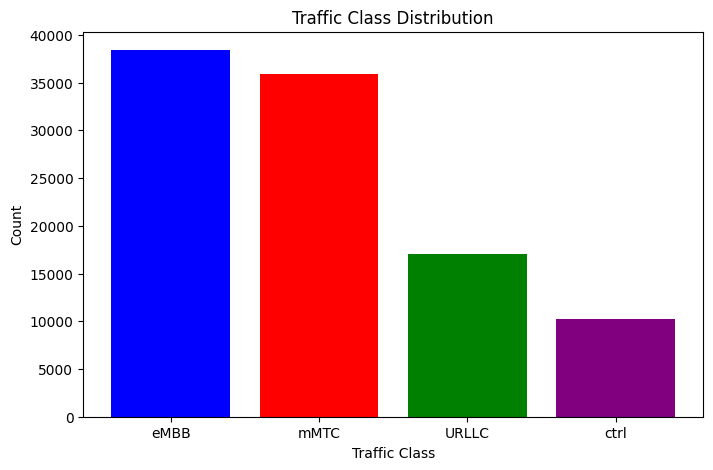

Class :  eMBB Entries :  38405
Out of 38405 samples, 26058 are Zero populated rows which is about 67.85%
Class :  mMTC Entries :  35886
Out of 35886 samples, 25923 are Zero populated rows which is about 72.24%
Class :  URLLC Entries :  17003
Out of 17003 samples, 1905 are Zero populated rows which is about 11.2%
Class :  ctrl Entries :  10230
Out of 10230 samples, 9618 are Zero populated rows which is about 94.02%

Rows with more than 11 zero KPIs are zero populated rows


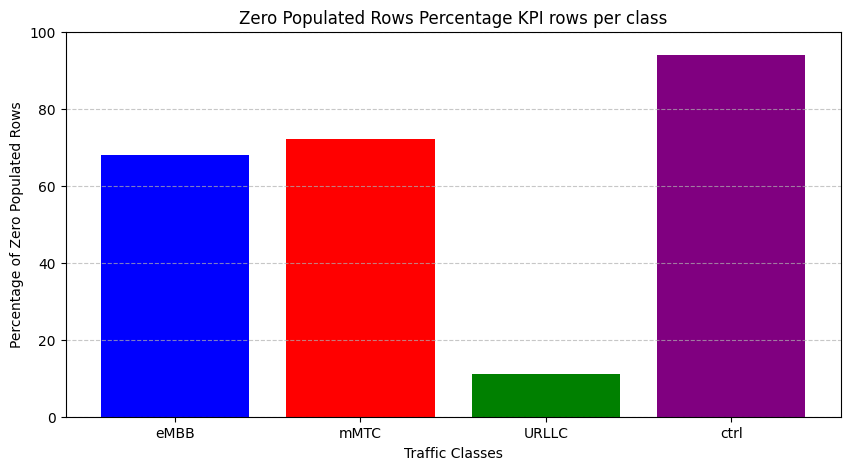

In [ ]:
# Function to generate and display graphs
def generate_graphs(df):
    graph_view = GraphView(df, labels)
    graph_view.generate_graphs()
generate_graphs(df)

In [ ]:
def applyHeuristic(df):
  obj=ApplyHeuristics(df)
  obj.applyHeuristic()
  obj.save_csv(df)
applyHeuristic(df)

File saved at /content/drive/My Drive/6G/CIP_Group_Sanjeev/logs/dataset_analysis.csv


# **Analysis**

**Mean and Standar deviation for each KPI within each class**

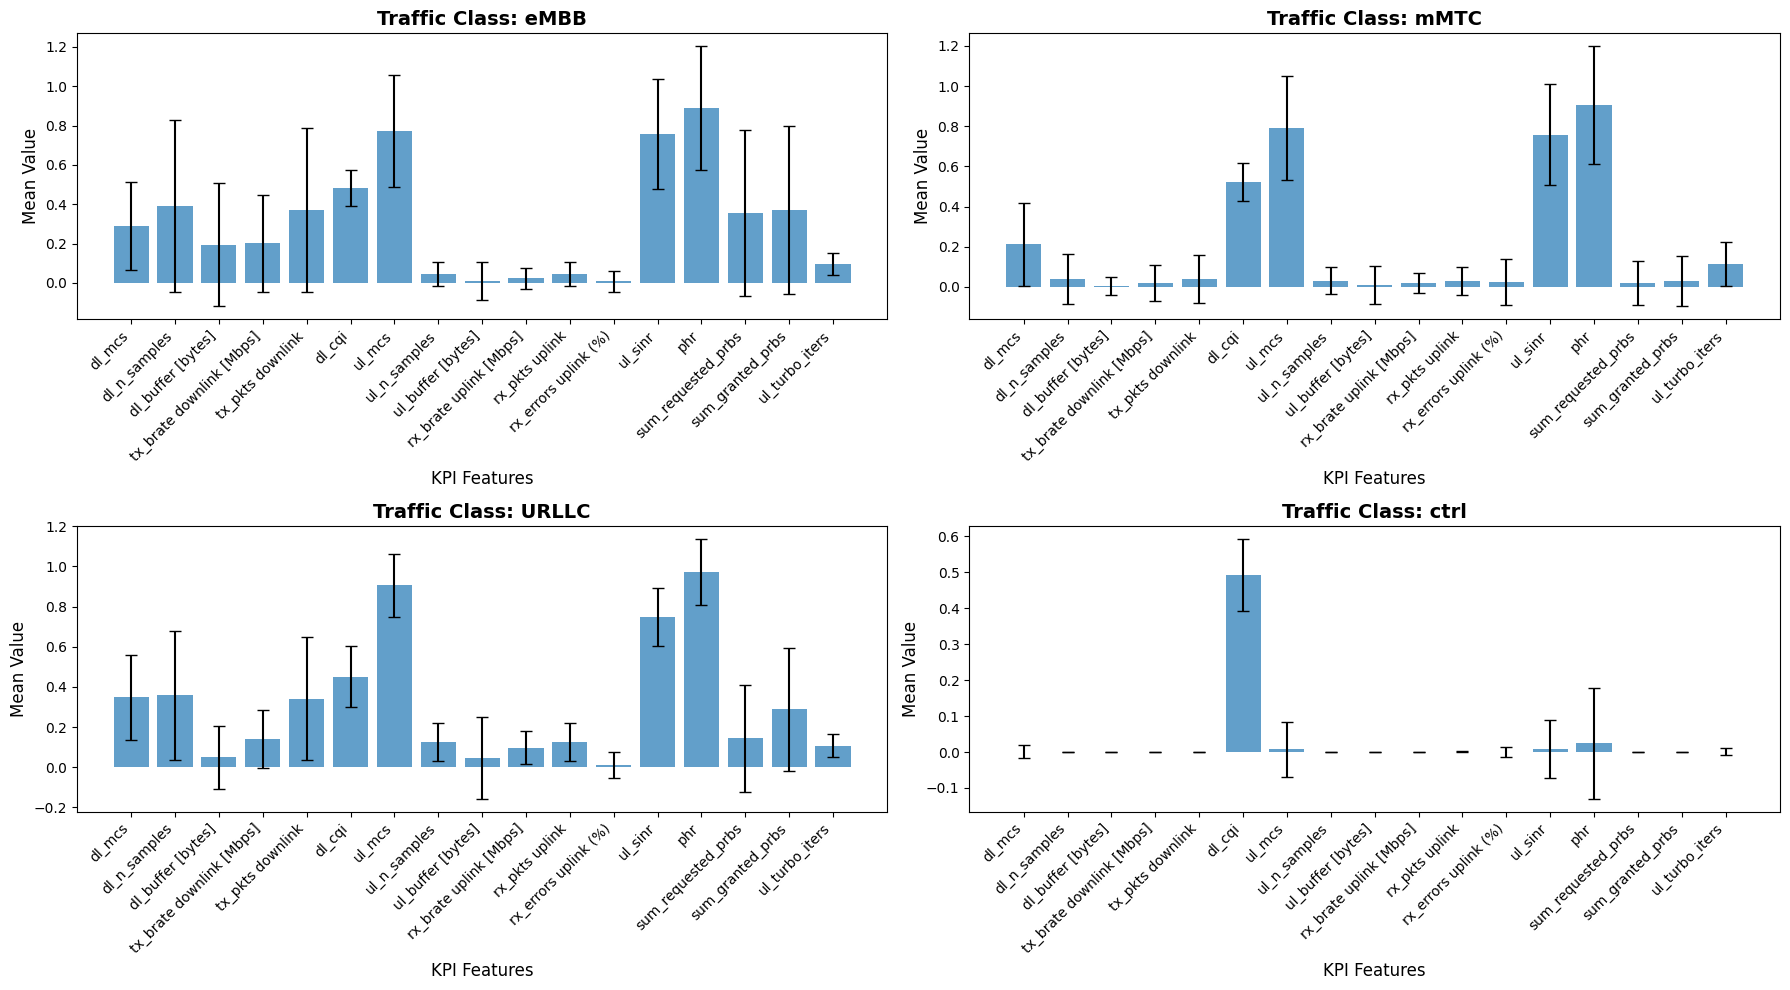

0: dl_mcs ; 1: dl_n_samples ; 2: dl_buffer [bytes] ; 3: tx_brate downlink [Mbps] ; 4: tx_pkts downlink ; 5: dl_cqi ; 6: ul_mcs ; 7: ul_n_samples ; 8: ul_buffer [bytes] ; 9: rx_brate uplink [Mbps] ; 10: rx_pkts uplink ; 11: rx_errors uplink (%) ; 12: ul_sinr ; 13: phr ; 14: sum_requested_prbs ; 15: sum_granted_prbs ; 16: ul_turbo_iters ; 

In [ ]:
def perform_kpi_analysis(df,no_zeros):
    kpi_analysis = KPIAnalysis(df, labels)
    kpi_analysis.plot_kpi_analysis(no_zeros=no_zeros)
    kpi_analysis.print_kpi_names()

perform_kpi_analysis(df,False)

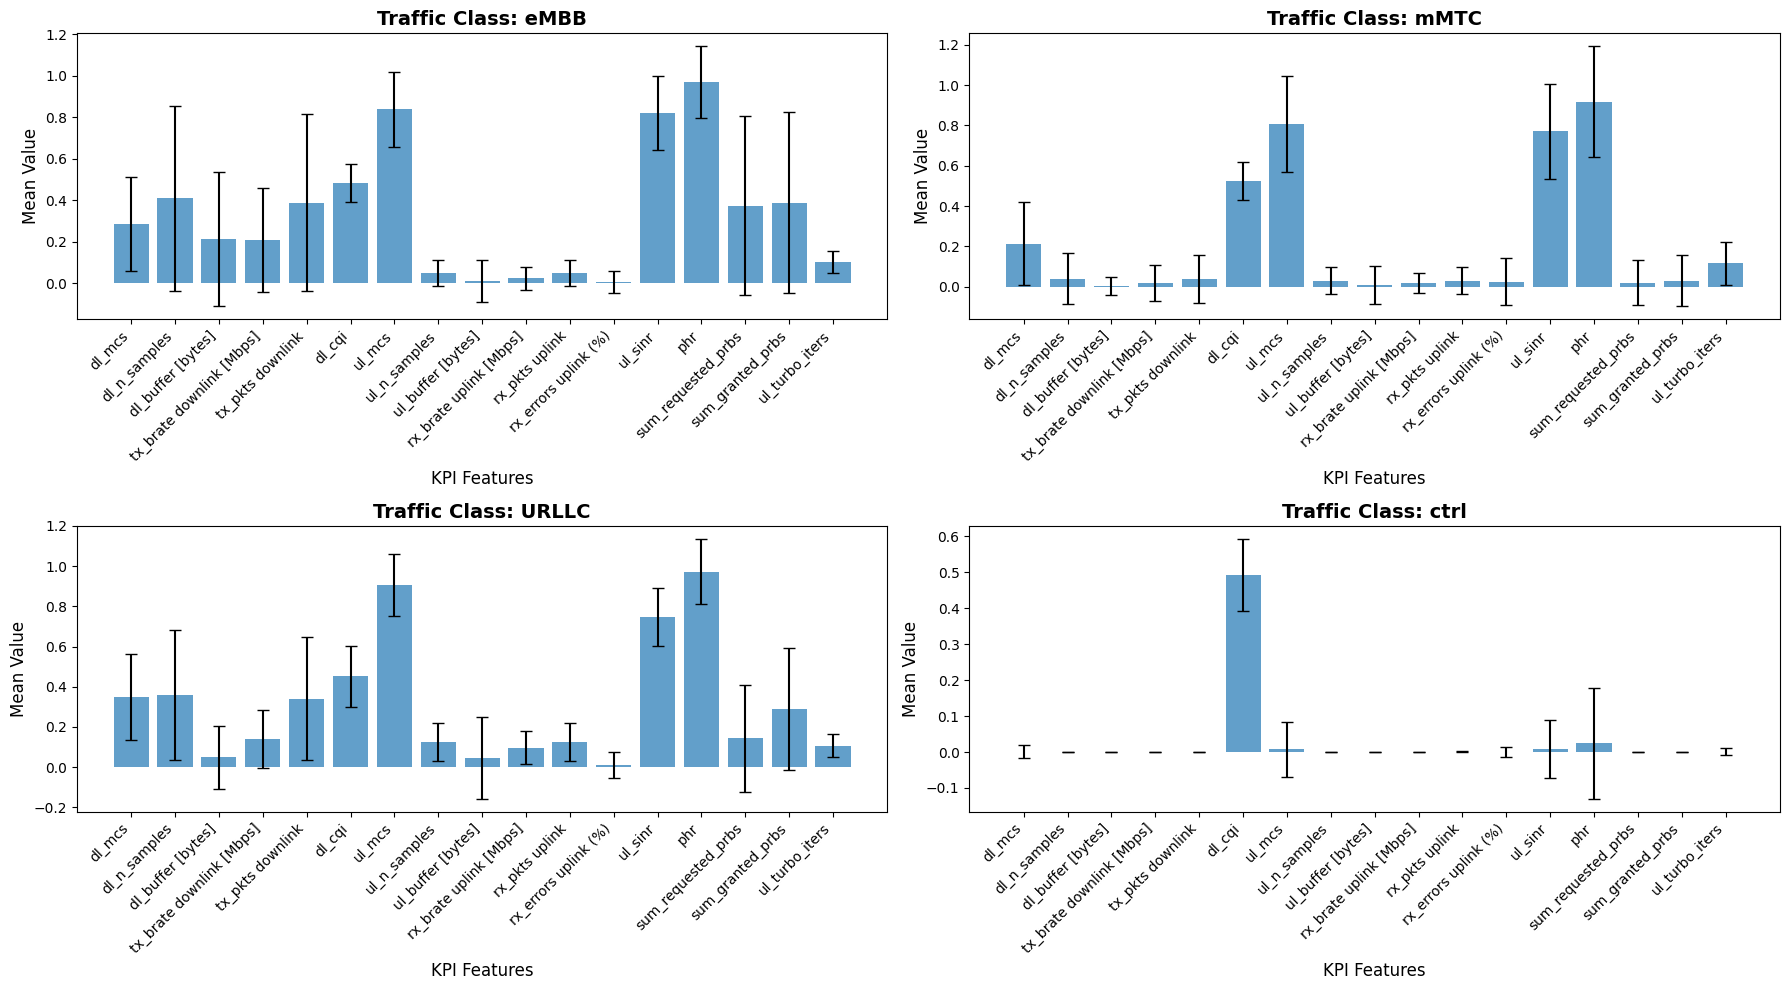

0: dl_mcs ; 1: dl_n_samples ; 2: dl_buffer [bytes] ; 3: tx_brate downlink [Mbps] ; 4: tx_pkts downlink ; 5: dl_cqi ; 6: ul_mcs ; 7: ul_n_samples ; 8: ul_buffer [bytes] ; 9: rx_brate uplink [Mbps] ; 10: rx_pkts uplink ; 11: rx_errors uplink (%) ; 12: ul_sinr ; 13: phr ; 14: sum_requested_prbs ; 15: sum_granted_prbs ; 16: ul_turbo_iters ; 

In [ ]:
perform_kpi_analysis(df,True)

# **PCA Dimensionality reduction**

Reducing the dimensioality to 10 all the way from the previously present 17 kpis

Explained Variance per Component: [0.72315911 0.18952342 0.02538969 0.01282311 0.01221121 0.00907883
 0.00844469 0.0067386  0.00469478 0.0032436 ]
Cumulative Variance Explained: [0.72315911 0.91268253 0.93807222 0.95089533 0.96310654 0.97218537
 0.98063005 0.98736865 0.99206343 0.99530703]
Total Variance Explained: 0.9953070301627885


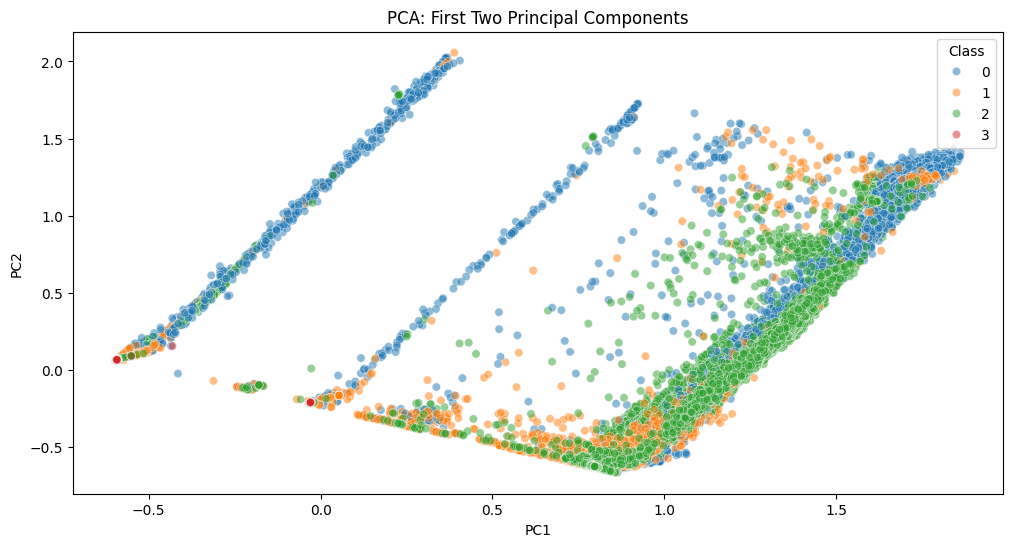

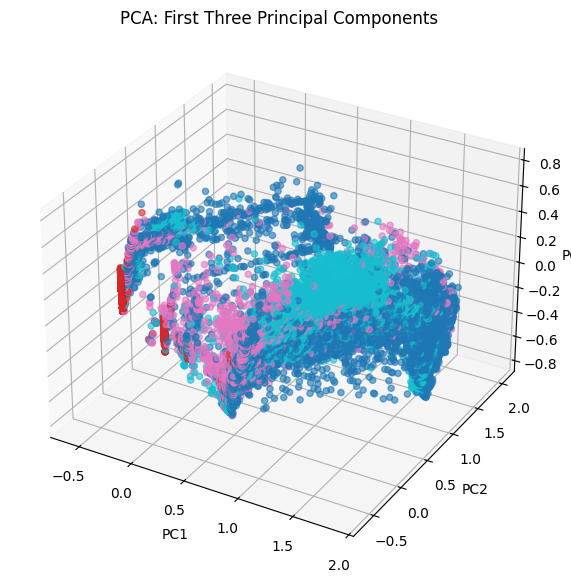

In [ ]:
def perform_pca_analysis(df, n_components=6):
    pca_analysis = PCAAnalysis(df, n_components=n_components)
    pca_analysis.explained_variance_summary()
    pca_analysis.plot_2d_pca()
    pca_analysis.plot_3d_pca()

    # Get PCA results as a dataframe
    df_pca = pca_analysis.get_pca_dataframe()
    return df_pca
df_pca=perform_pca_analysis(df,n_components=10)


In [ ]:
print(df_pca)

             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0       0.784609 -0.574146 -0.161459  0.031721  0.026406 -0.042100  0.008672   
1       0.776632 -0.581826 -0.143628  0.067952  0.039633 -0.036084  0.012267   
2       0.803397 -0.568572  0.011296  0.105346  0.046883 -0.139579  0.135090   
3      -0.595122  0.063424 -0.028783 -0.039238 -0.022748 -0.026891  0.015896   
4      -0.595195  0.063338 -0.024391 -0.032070 -0.020057 -0.021273  0.012342   
...          ...       ...       ...       ...       ...       ...       ...   
101519  1.618127  1.091586 -0.549573 -0.004267 -0.025782  0.000288  0.051065   
101520  1.616677  1.092289 -0.544500 -0.009878 -0.024791 -0.001218  0.042331   
101521  1.603779  1.101394 -0.518967 -0.063559 -0.013991  0.021360  0.021484   
101522  1.619934  1.091899 -0.551011 -0.000845 -0.026765 -0.003182  0.047565   
101523  1.604907  1.081291 -0.610331 -0.027297 -0.033164  0.001540  0.037255   

             PC8       PC9      PC10  l

# **TSNE dimensionality reduction**

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 101524 samples in 0.017s...
[t-SNE] Computed neighbors for 101524 samples in 95.937s...
[t-SNE] Computed conditional probabilities for sample 1000 / 101524
[t-SNE] Computed conditional probabilities for sample 2000 / 101524
[t-SNE] Computed conditional probabilities for sample 3000 / 101524
[t-SNE] Computed conditional probabilities for sample 4000 / 101524
[t-SNE] Computed conditional probabilities for sample 5000 / 101524
[t-SNE] Computed conditional probabilities for sample 6000 / 101524
[t-SNE] Computed conditional probabilities for sample 7000 / 101524
[t-SNE] Computed conditional probabilities for sample 8000 / 101524
[t-SNE] Computed conditional probabilities for sample 9000 / 101524
[t-SNE] Computed conditional probabilities for sample 10000 / 101524
[t-SNE] Computed conditional probabilities for sample 11000 / 101524
[t-SNE] Computed conditional probabilities for sample 12000 / 101524
[t-SNE] Computed conditional probab

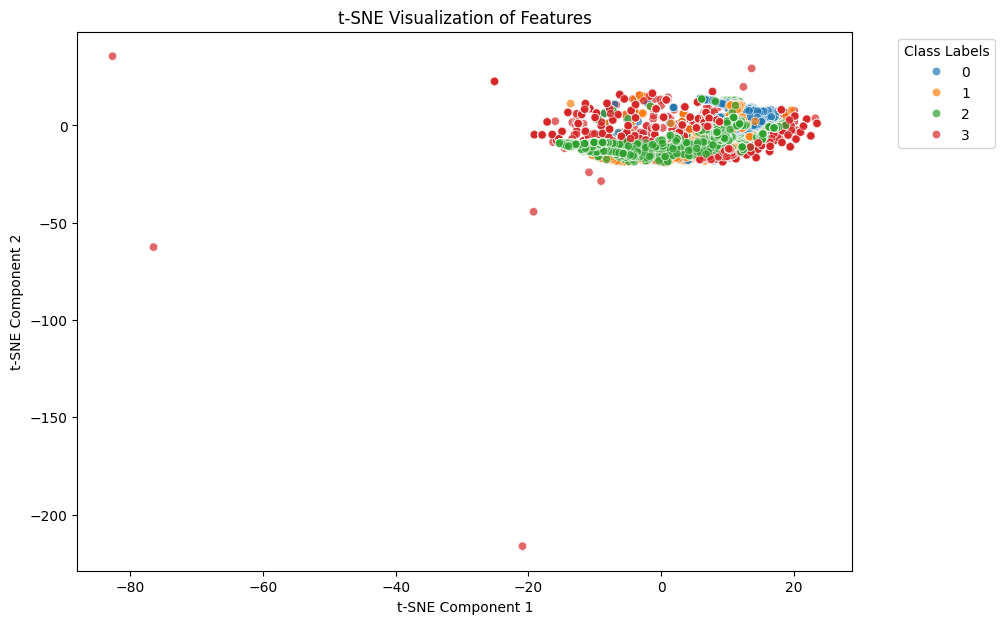

In [ ]:
def perform_tsne_analysis(df):
    tsne_analysis = TSNEAnalysis(df)
    tsne_analysis.plot_tsne()

    # Get t-SNE results as a dataframe
    df_tsne = tsne_analysis.get_tsne_results()
    return df_tsne
df_tsne=perform_tsne_analysis(df)

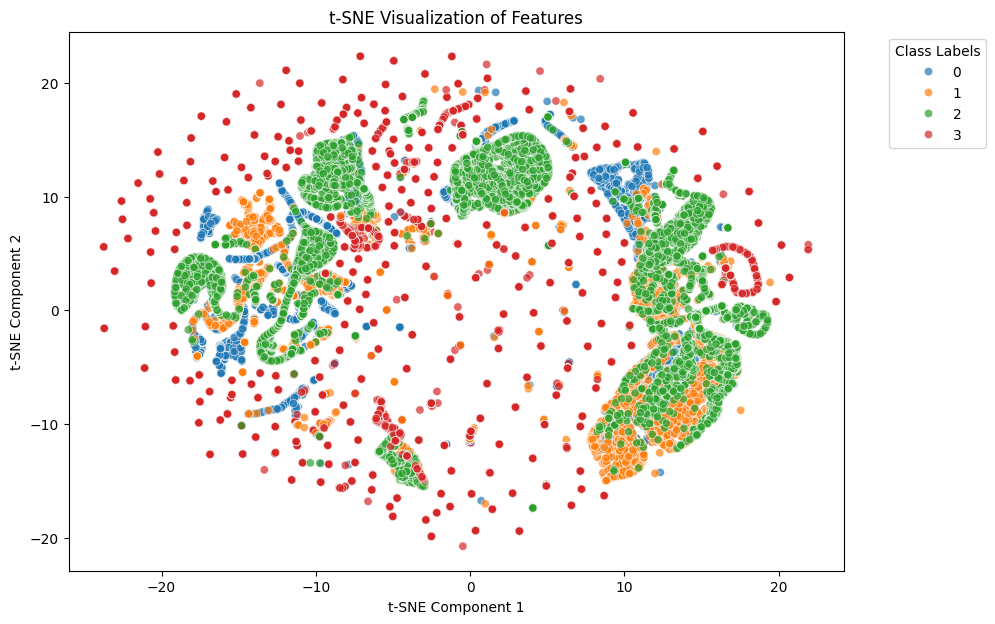

# **UMAP Dimensionality Reduction**

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


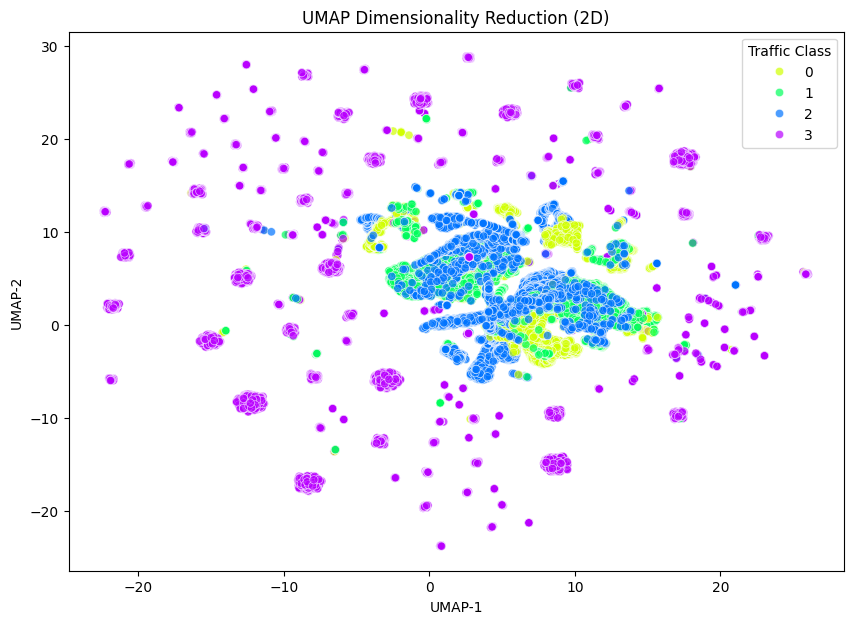

In [ ]:
# Function to perform UMAP analysis and return the transformed dataframe
def perform_umap_analysis(df):
    umap_analysis = UMAPAnalysis(df)
    umap_analysis.plot_umap()

    # Get UMAP results as a dataframe
    df_umap = umap_analysis.get_umap_results()
    return df_umap
df_umap=perform_umap_analysis(df)

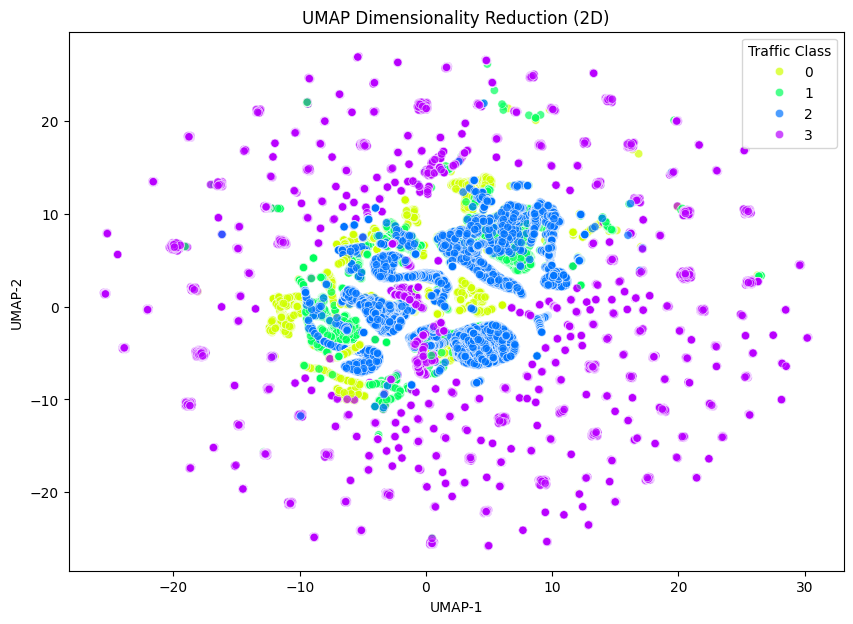

# **Training the Random Forest Model**

**For PCA reduced data**

Random Forest Accuracy: 0.94

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.83      0.84      2496
           1       0.76      0.78      0.77      1992
           2       0.91      0.92      0.92      3020
           3       1.00      0.99      0.99     12797

    accuracy                           0.94     20305
   macro avg       0.88      0.88      0.88     20305
weighted avg       0.94      0.94      0.94     20305



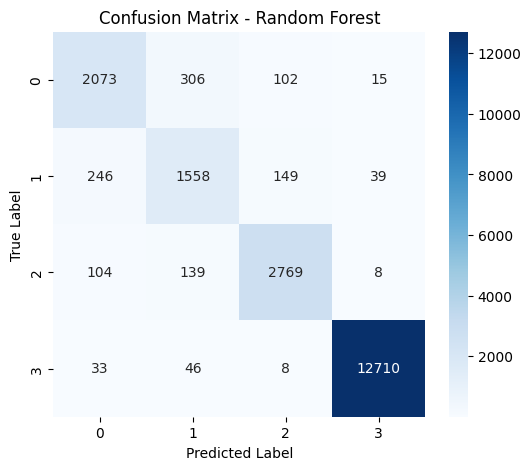

RandomForestClassifier(random_state=42)

In [ ]:
def run_random_forest(df_pca):
    rf_model = RandomForestModel(data=df_pca, label_column='label')
    rf_model.run()
    return rf_model.rf_model
run_random_forest(df_pca)

**For UMAP reduced data**

Random Forest Accuracy: 0.92

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.75      0.76      2496
           1       0.69      0.71      0.70      1992
           2       0.88      0.88      0.88      3020
           3       0.99      0.99      0.99     12797

    accuracy                           0.92     20305
   macro avg       0.83      0.83      0.83     20305
weighted avg       0.92      0.92      0.92     20305



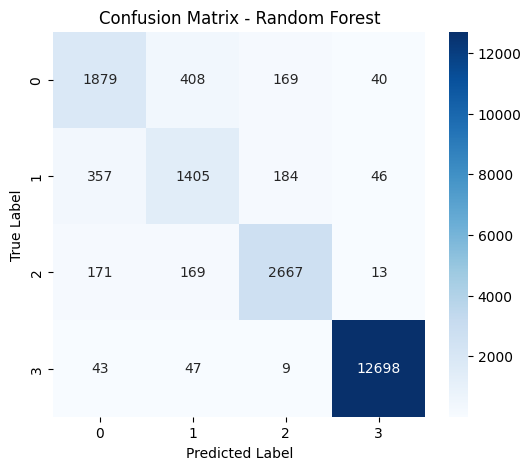

RandomForestClassifier(random_state=42)

In [ ]:
run_random_forest(df_umap)

**For TSNE reduced data**

Random Forest Accuracy: 0.92

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.79      2496
           1       0.70      0.71      0.70      1992
           2       0.88      0.88      0.88      3020
           3       0.99      0.99      0.99     12797

    accuracy                           0.92     20305
   macro avg       0.84      0.84      0.84     20305
weighted avg       0.92      0.92      0.92     20305



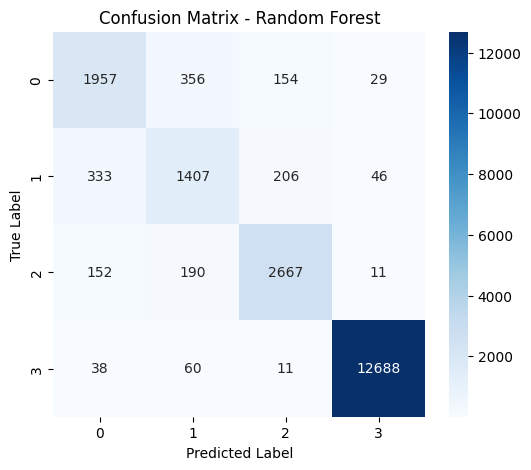

RandomForestClassifier(random_state=42)

In [ ]:
run_random_forest(df_tsne)

# **Training the XGBoost model**

**For PCA reduced data**

XGBoost Accuracy: 0.94

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.79      0.82      2496
           1       0.72      0.81      0.76      1992
           2       0.91      0.92      0.91      3020
           3       1.00      0.99      0.99     12797

    accuracy                           0.94     20305
   macro avg       0.87      0.88      0.87     20305
weighted avg       0.94      0.94      0.94     20305



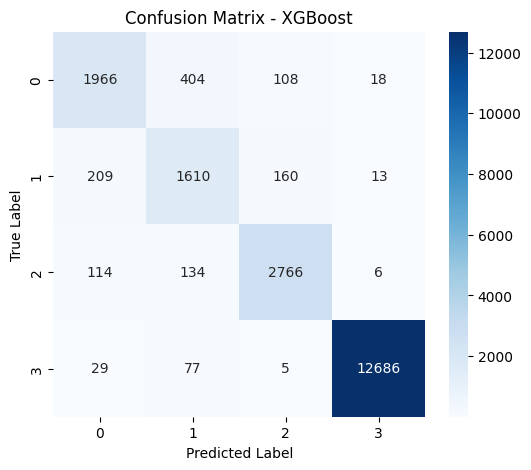

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
# Function to train and evaluate XGBoost model
def run_xgboost(df_pca):
    xgb_model = XGBModel(data=df_pca, label_column='label')
    xgb_model.run()
    return xgb_model.xgb_model
run_xgboost(df_pca)

**For TSNE reduced data**

XGBoost Accuracy: 0.92

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.77      2496
           1       0.69      0.72      0.71      1992
           2       0.87      0.89      0.88      3020
           3       0.99      0.99      0.99     12797

    accuracy                           0.92     20305
   macro avg       0.83      0.84      0.84     20305
weighted avg       0.92      0.92      0.92     20305



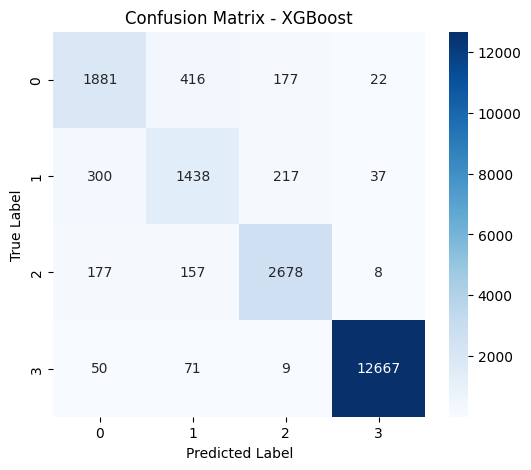

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
run_xgboost(df_tsne)

**For UMAP reduced data**

XGBoost Accuracy: 0.92

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.73      0.75      2496
           1       0.69      0.72      0.71      1992
           2       0.85      0.91      0.88      3020
           3       1.00      0.99      0.99     12797

    accuracy                           0.92     20305
   macro avg       0.83      0.84      0.83     20305
weighted avg       0.92      0.92      0.92     20305



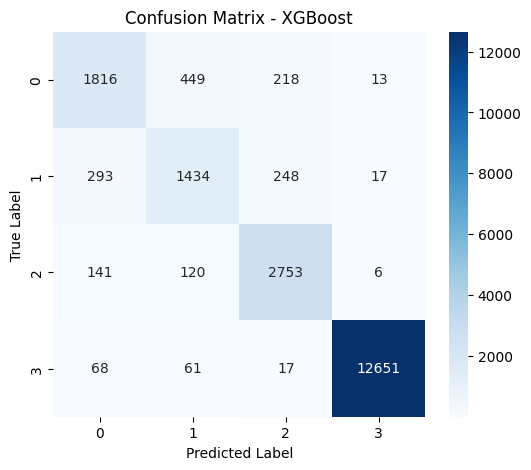

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
run_xgboost(df_umap)

# **Training Support Vector Machine model**

**For PCA reduced data**

In [ ]:
def run_svm(df_pca):
    svm_model = SVMModel(data=df_pca, label_column='label')
    svm_model.run()
    return svm_model.svm_model

SVM Accuracy: 0.91

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.67      0.74      2496
           1       0.62      0.76      0.68      1992
           2       0.86      0.88      0.87      3020
           3       0.99      0.99      0.99     12797

    accuracy                           0.91     20305
   macro avg       0.82      0.82      0.82     20305
weighted avg       0.92      0.91      0.91     20305



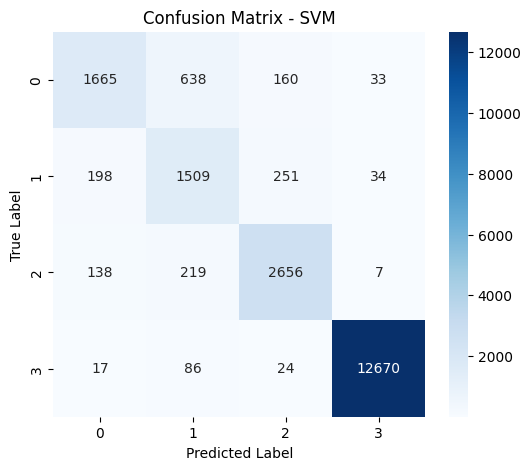

SVC(random_state=42)

In [ ]:
run_svm(df_pca)

**For TSNE reduced data**

SVM Accuracy: 0.86

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.65      0.64      2496
           1       0.58      0.46      0.51      1992
           2       0.76      0.81      0.78      3020
           3       0.97      0.98      0.98     12797

    accuracy                           0.86     20305
   macro avg       0.74      0.72      0.73     20305
weighted avg       0.86      0.86      0.86     20305



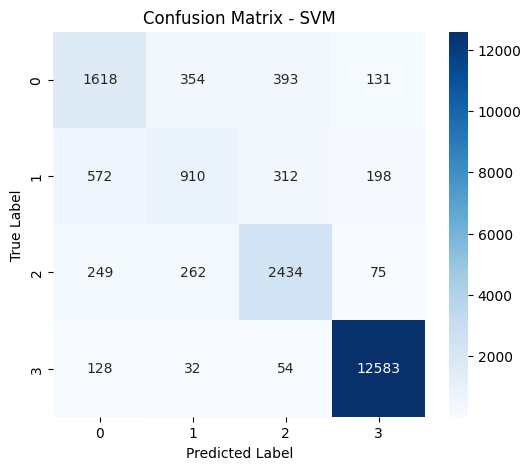

SVC(random_state=42)

In [ ]:
run_svm(df_tsne)

**For UMAP reduced data**

SVM Accuracy: 0.84

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.33      0.43      2496
           1       0.57      0.57      0.57      1992
           2       0.59      0.84      0.69      3020
           3       0.99      0.99      0.99     12797

    accuracy                           0.84     20305
   macro avg       0.69      0.68      0.67     20305
weighted avg       0.85      0.84      0.84     20305



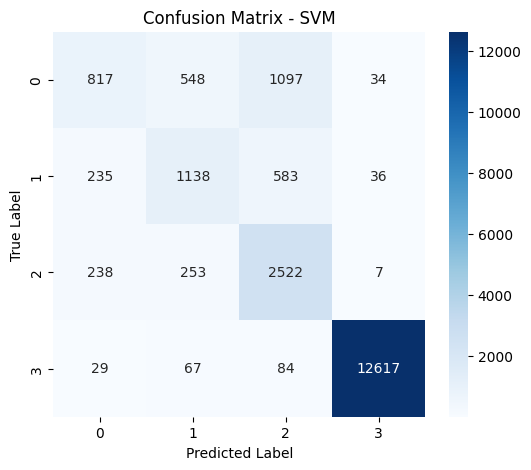

SVC(random_state=42)

In [ ]:
run_svm(df_umap)